In [40]:
# Import and Setup

In [42]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Set matplotlib style
plt.style.use('ggplot')
%matplotlib inline

# Define paths
TRAIN_DIR = './data/HAM10000_images/train_dir'
VAL_DIR = './data/HAM10000_images/val_dir'
MODEL_SAVE_PATH = './models/skin_lesion_detection.keras'
SEGMENTATION_DIR = './data/segmented_lesions'  
IMG_SIZE = (192, 192)  
BATCH_SIZE = 16  

# Create directories
os.makedirs('./models', exist_ok=True)
os.makedirs('./plots', exist_ok=True)
os.makedirs(SEGMENTATION_DIR, exist_ok=True)

In [43]:
# Load and analyze data from directories

Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Training images: 38569
Validation images: 938


<Figure size 1200x1000 with 0 Axes>

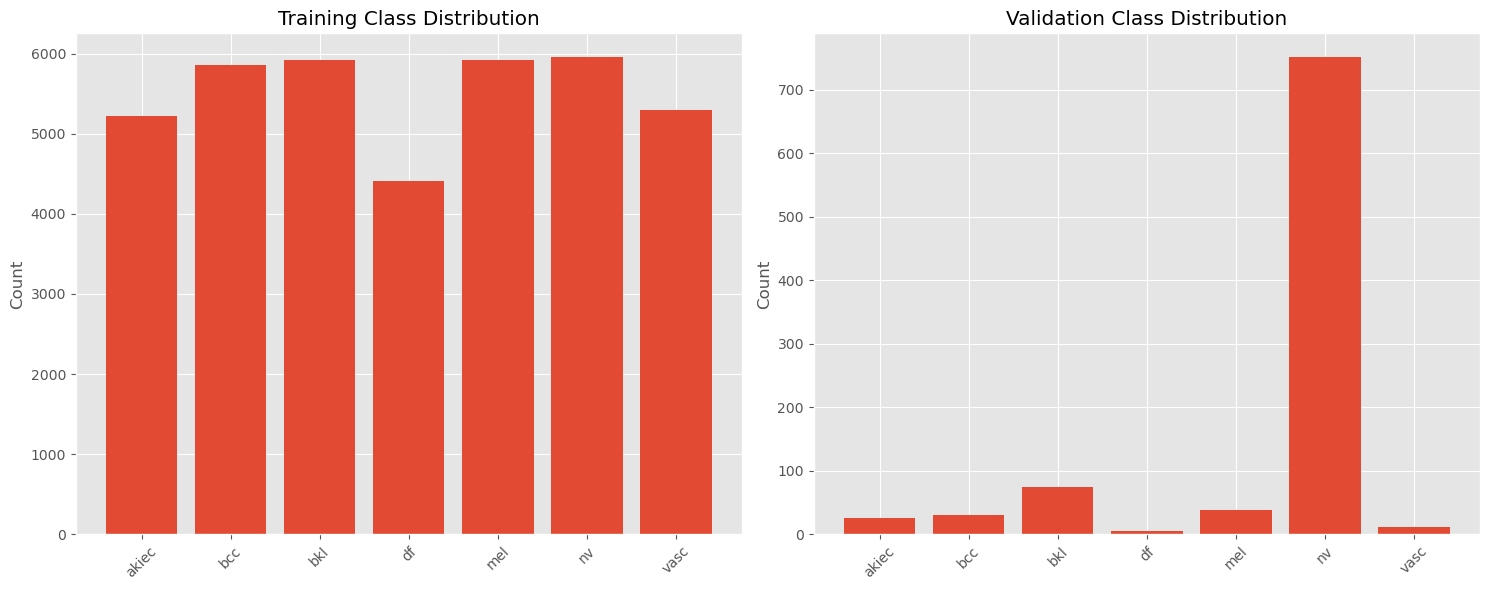

In [44]:
def load_data_from_directories(train_dir, val_dir):
    """Load image paths and labels from directory structure"""
    # Get class names from subdirectories
    class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
    
    # Load training data
    train_image_paths = []
    train_labels = []
    train_label_names = []
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(train_dir, class_name)
        for img_name in os.listdir(class_dir):
            if img_name.endswith(('.jpg', '.jpeg', '.png')):
                train_image_paths.append(os.path.join(class_dir, img_name))
                train_labels.append(class_idx)
                train_label_names.append(class_name)
    
    # Load validation data
    val_image_paths = []
    val_labels = []
    val_label_names = []
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(val_dir, class_name)
        for img_name in os.listdir(class_dir):
            if img_name.endswith(('.jpg', '.jpeg', '.png')):
                val_image_paths.append(os.path.join(class_dir, img_name))
                val_labels.append(class_idx)
                val_label_names.append(class_name)
    
    return (train_image_paths, train_labels, train_label_names, 
            val_image_paths, val_labels, val_label_names, class_names)

# Load the data
(train_paths, train_labels, train_label_names, 
 val_paths, val_labels, val_label_names, class_names) = load_data_from_directories(TRAIN_DIR, VAL_DIR)

print(f'Classes: {class_names}')
print(f'Training images: {len(train_paths)}')
print(f'Validation images: {len(val_paths)}')

# Enhanced visualization: Class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training distribution
train_counts = [train_label_names.count(cls) for cls in class_names]
axes[0].bar(class_names, train_counts)
axes[0].set_title('Training Class Distribution')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Validation distribution
val_counts = [val_label_names.count(cls) for cls in class_names]
axes[1].bar(class_names, val_counts)
axes[1].set_title('Validation Class Distribution')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('./plots/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [45]:
# Sample images visualization

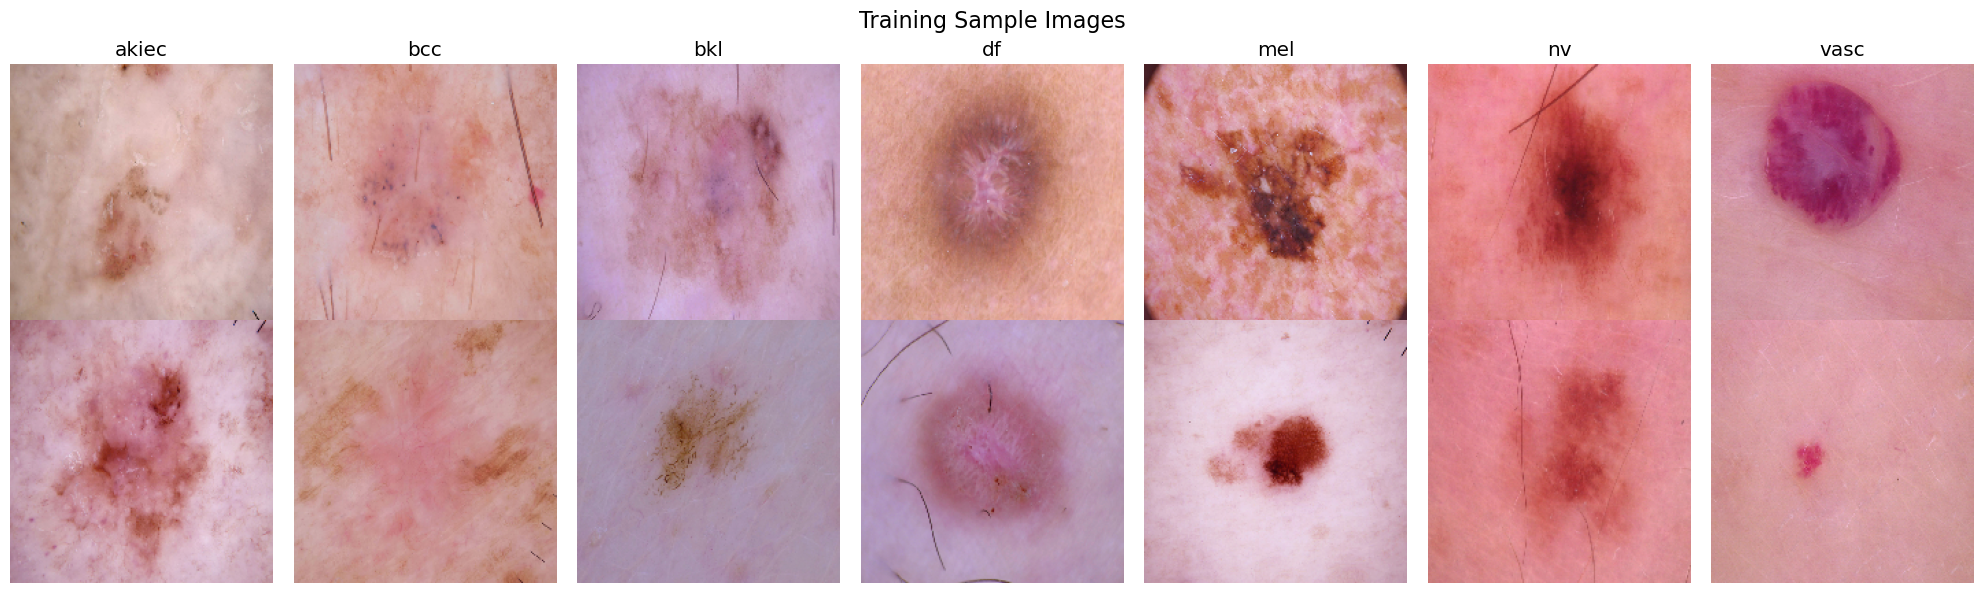

In [46]:
def visualize_sample_images(image_paths, labels, label_names, class_names, title):
    """Visualize sample images from each class"""
    n_classes = len(class_names)
    fig, axes = plt.subplots(2, n_classes, figsize=(20, 6))
    
    for i, class_name in enumerate(class_names):
        # Find first two images of this class
        class_indices = [idx for idx, name in enumerate(label_names) if name == class_name]
        
        for j in range(2):
            if j < len(class_indices):
                img_path = image_paths[class_indices[j]]
                img = load_img(img_path, target_size=IMG_SIZE)
                axes[j, i].imshow(img)
                axes[j, i].set_title(f'{class_name}' if j == 0 else '')
                axes[j, i].axis('off')
            else:
                axes[j, i].axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.savefig(f'./plots/{title.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize training samples
visualize_sample_images(train_paths, train_labels, train_label_names, class_names, 
                       'Training Sample Images')

In [47]:
# Simplified U-Net Segmentation Model

In [48]:
def create_simplified_unet(input_shape=(192, 192, 3)):
    """Create a simplified U-Net model optimized for CPU"""
    inputs = layers.Input(shape=input_shape)
    
    # Downsample path
    # Block 1
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Block 2
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Block 3 (Bridge)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    
    # Upsample path
    # Block 4
    up4 = layers.UpSampling2D(size=(2, 2))(conv3)
    up4 = layers.Conv2D(64, (2, 2), activation='relu', padding='same')(up4)
    merge4 = layers.concatenate([conv2, up4], axis=3)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge4)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    
    # Block 5
    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.Conv2D(32, (2, 2), activation='relu', padding='same')(up5)
    merge5 = layers.concatenate([conv1, up5], axis=3)
    conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(merge5)
    conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    
    # Output
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv5)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Create segmentation model
segmentation_model = create_simplified_unet()
segmentation_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 192, 192, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_13 (Conv2D)            │ (None, 192, 192, 32)      │             896 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_14 (Conv2D)            │ (None, 192, 192, 32)      │           9,248 │ conv2d_13[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 96, 96, 32)        │               0 │ conv2d_14[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_15 (Conv2D)            │ (None, 96, 96, 64)        │          18,496 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_16 (Conv2D)            │ (None, 96, 96, 64)        │          36,928 │ conv2d_15[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 48, 48, 64)        │               0 │ conv2d_16[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_17 (Conv2D)            │ (None, 48, 48, 128)       │          73,856 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_18 (Conv2D)            │ (None, 48, 48, 128)       │         147,584 │ conv2d_17[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_2               │ (None, 96, 96, 128)       │               0 │ conv2d_18[0][0]            │
│ (UpSampling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_19 (Conv2D)            │ (None, 96, 96, 64)        │          32,832 │ up_sampling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)   │ (None, 96, 96, 128)       │               0 │ conv2d_16[0][0],           │
│                               │                           │                 │ conv2d_19[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_20 (Conv2D)            │ (None, 96, 96, 64)        │          73,792 │ concatenate_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_21 (Conv2D)            │ (None, 96, 96, 64)        │          36,928 │ conv2d_20[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_3               │ (None, 192, 192, 64)      │               0 │ conv2d_21[0][0]            │
│ (UpSampling2D)                │                           │               

 Total params: 466,529 (1.78 MB)

 Trainable params: 466,529 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Create simple masks for training

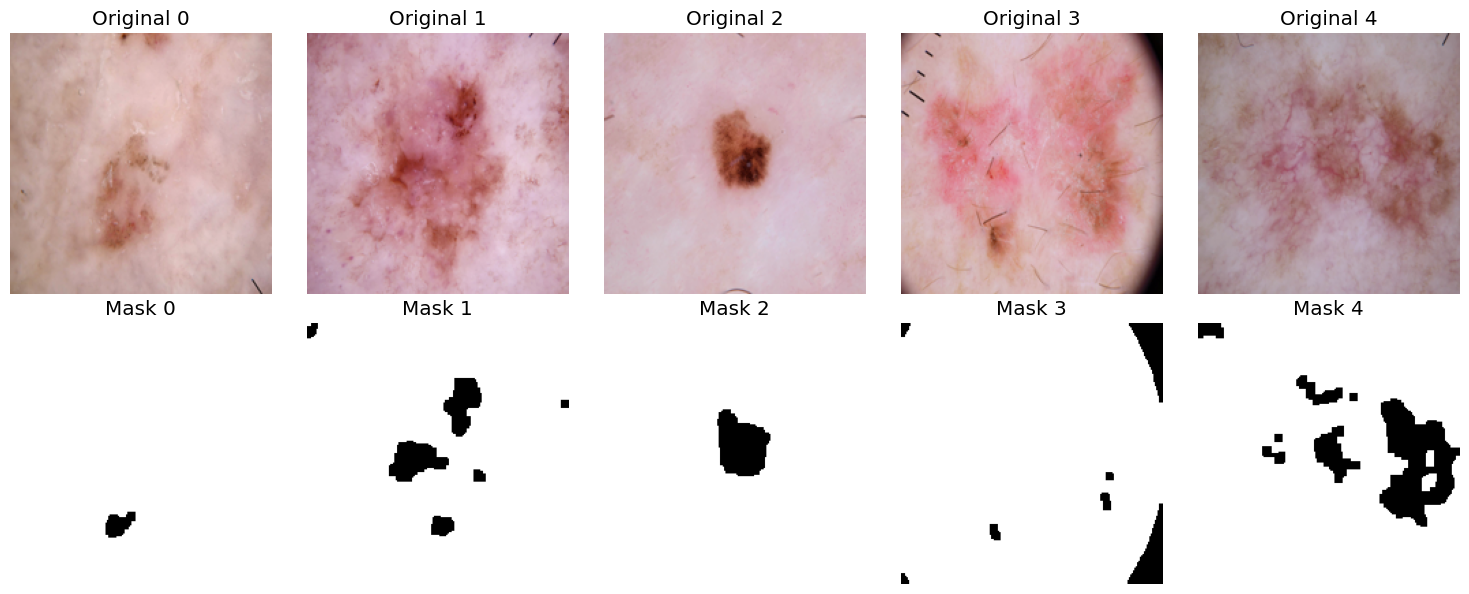

In [50]:
def create_simple_mask(image_path):
    """Create a simple circular mask approximation for training"""
    img = Image.open(image_path).resize(IMG_SIZE)
    img_array = np.array(img)
    
    # Convert to uint8 for OpenCV operations
    img_array_uint8 = (img_array).astype(np.uint8)
    
    # Simple threshold-based mask
    gray = cv2.cvtColor(img_array_uint8, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 127, 1, cv2.THRESH_BINARY)
    
    # Apply morphological operations to clean up
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    return mask.astype(np.float32)  # Return as float32 for training

# Visualize sample masks
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    img_path = train_paths[i]
    
    # Original image
    img = Image.open(img_path).resize(IMG_SIZE)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Original {i}')
    axes[0, i].axis('off')
    
    # Generated mask
    mask = create_simple_mask(img_path)
    axes[1, i].imshow(mask, cmap='gray')
    axes[1, i].set_title(f'Mask {i}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('./plots/sample_masks.png', dpi=300, bbox_inches='tight')
plt.show()

In [52]:
# Train segmentation model

Training segmentation model...
Epoch 1/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.7757 - loss: 0.5423 - precision_2: 0.9199 - recall_2: 0.8240 - val_accuracy: 0.9007 - val_loss: 0.2513 - val_precision_2: 0.9007 - val_recall_2: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.9295 - loss: 0.1693 - precision_2: 0.9295 - recall_2: 1.0000 - val_accuracy: 0.9031 - val_loss: 0.2543 - val_precision_2: 0.9029 - val_recall_2: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.9463 - loss: 0.1276 - precision_2: 0.9512 - recall_2: 0.9932 - val_accuracy: 0.9283 - val_loss: 0.1748 - val_precision_2: 0.9373 - val_recall_2: 0.9864 - learning_rate: 1.0000e-04
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9641 - loss: 0.0887 - precision_2: 0.9719 - recall_2: 0.9900 - val_accuracy: 0.9695 - val_loss: 0.0710 - val_precision_2: 0.9860 - val_recall_2: 0.9800 - learning_rate: 1.00

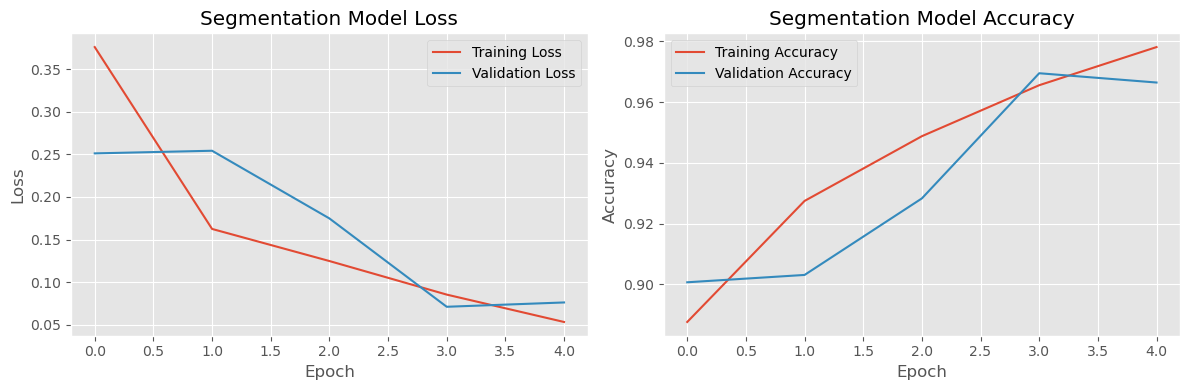

In [54]:
def train_segmentation_model(image_paths, epochs=5):
    """Train the segmentation model with generated masks"""
    # Prepare training data
    X_train = []
    y_train = []
    
    for img_path in image_paths[:800]:  # Use subset for training on CPU
        img = Image.open(img_path).resize(IMG_SIZE)
        img_array = np.array(img) / 255.0
        mask = create_simple_mask(img_path)
        
        X_train.append(img_array)
        y_train.append(mask)
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = np.expand_dims(y_train, axis=-1)
    
    # Compile model
    segmentation_model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    
    # Callbacks
    seg_callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
    ]
    
    # Train
    history = segmentation_model.fit(
        X_train, y_train,
        batch_size=8,
        epochs=epochs,
        validation_split=0.2,
        callbacks=seg_callbacks,
        verbose=1
    )
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Segmentation Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Segmentation Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('./plots/segmentation_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return history

# Train segmentation model
print("Training segmentation model...")
seg_history = train_segmentation_model(train_paths, epochs=5)

In [55]:
# Segment all images and save segmented lesions

In [ ]:
def segment_and_save_images_batch(image_paths, output_dir, batch_size=32):
    """Segment all images in batches and save the segmented lesions - MUCH FASTER!"""
    segmented_paths = []
    
    # Process in batches
    for batch_start in range(0, len(image_paths), batch_size):
        batch_end = min(batch_start + batch_size, len(image_paths))
        batch_paths = image_paths[batch_start:batch_end]
        
        # Load and preprocess batch
        batch_images = []
        for img_path in batch_paths:
            img = Image.open(img_path).resize(IMG_SIZE)
            img_array = np.array(img) / 255.0
            batch_images.append(img_array)
        
        batch_images = np.array(batch_images)
        
        # Predict masks for entire batch
        masks = segmentation_model.predict(batch_images, verbose=0)
        masks = (masks > 0.5).astype(np.uint8)
        
        # Apply masks to original images
        segmented_batch = batch_images * np.repeat(masks, 3, axis=-1)
        
        # Save segmented images
        for i, segmented in enumerate(segmented_batch):
            img_name = os.path.basename(batch_paths[i])
            output_path = os.path.join(output_dir, img_name)
            segmented_img = Image.fromarray((segmented * 255).astype(np.uint8))
            segmented_img.save(output_path)
            segmented_paths.append(output_path)
            
    return segmented_paths

# Segment training images 
print("Segmenting training images...")
segmented_train_paths = segment_and_save_images_batch(train_paths, SEGMENTATION_DIR, batch_size=32)

# Segment validation images
print("Segmenting validation images...")
segmented_val_paths = segment_and_save_images_batch(val_paths, SEGMENTATION_DIR, batch_size=32)

print("Segmentation completed!")

Segmenting training images...


In [ ]:
# Visualize segmentation results

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
for i in range(5):
    # Original image
    img = Image.open(train_paths[i]).resize(IMG_SIZE)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Original {i}')
    axes[0, i].axis('off')
    
    # Predicted mask
    img_array = np.array(img) / 255.0
    mask = segmentation_model.predict(np.expand_dims(img_array, axis=0), verbose=0)[0]
    axes[1, i].imshow(mask.squeeze(), cmap='gray')
    axes[1, i].set_title(f'Predicted Mask {i}')
    axes[1, i].axis('off')
    
    # Segmented lesion
    segmented_img = Image.open(segmented_train_paths[i])
    axes[2, i].imshow(segmented_img)
    axes[2, i].set_title(f'Segmented {i}')
    axes[2, i].axis('off')  # Fixed the syntax error here

plt.tight_layout()
plt.savefig('./plots/segmentation_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Create data generators for CLASSIFICATION

In [ ]:
def create_classification_generators(train_paths, train_labels, val_paths, val_labels):
    """Create data generators for classification with heavy augmentation"""
    # Convert to strings for categorical mode
    train_labels_str = [str(label) for label in train_labels]
    val_labels_str = [str(label) for label in val_labels]
    
    # Create dataframes
    train_df = pd.DataFrame({'filename': train_paths, 'class': train_labels_str})
    val_df = pd.DataFrame({'filename': val_paths, 'class': val_labels_str})
    
    # HEAVY augmentation like the paper
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.4,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant',
        cval=0,  # Fill with black (background)
        brightness_range=[0.7, 1.3],
        channel_shift_range=0.2
    )
    
    # Validation generators
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    # Create generators
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='class',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=SEED
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        x_col='filename',
        y_col='class',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_generator, val_generator

# Create generators for SEGMENTED images
train_gen, val_gen = create_classification_generators(
    segmented_train_paths, train_labels, segmented_val_paths, val_labels
)

In [ ]:
# Create EfficientNet-based classifier

In [ ]:
def create_efficient_classifier(num_classes=7, input_shape=(192, 192, 3)):
    """Create EfficientNet-based classifier"""
    base_model = EfficientNetB0(
        weights='imagenet', 
        include_top=False, 
        input_shape=input_shape
    )
    
    # Freeze initial layers
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    # Add custom head
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

# Create and compile classifier
classifier = create_efficient_classifier(len(class_names))
classifier.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall', tf.keras.metrics.AUC(name='auc')]
)
classifier.summary()

In [ ]:
# Train classifier with callbacks

In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint('./models/classifier_best.keras', monitor='val_accuracy', 
                   save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger('./models/training_history.csv')
]

# Calculate steps per epoch 
steps_per_epoch = min(200, len(train_paths) // BATCH_SIZE)
validation_steps = min(50, len(val_paths) // BATCH_SIZE)

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

# Train classifier
print("Training classifier...")
history = classifier.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

In [ ]:
# Enhanced evaluation and visualization

In [ ]:
# Evaluate model
val_gen.reset()
val_results = classifier.evaluate(val_gen, verbose=1)
print(f"Validation Accuracy: {val_results[1]:.4f}")
print(f"Validation Precision: {val_results[2]:.4f}")
print(f"Validation Recall: {val_results[3]:.4f}")
print(f"Validation AUC: {val_results[4]:.4f}")

# Predictions
val_gen.reset()
y_pred = classifier.predict(val_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels from the generator
y_true = val_gen.classes  # This is the correct way to get true labels

# Enhanced Confusion Matrix
plt.figure(figsize=(12, 10))  # Increased size for better readability
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Number of Images'})
plt.title('Confusion Matrix', fontsize=16, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./plots/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# ROC curves - FIXED
plt.figure(figsize=(12, 10))
for i, class_name in enumerate(class_names):
    # Convert to binary classification for each class
    y_true_binary = (y_true == i).astype(int)  # This was the problematic line
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for Each Class', fontsize=16, pad=20)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./plots/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Precision-Recall curves - FIXED
plt.figure(figsize=(12, 10))
for i, class_name in enumerate(class_names):
    y_true_binary = (y_true == i).astype(int)  # Fixed here too
    precision, recall, _ = precision_recall_curve(y_true_binary, y_pred[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{class_name} (AUC = {pr_auc:.2f})', linewidth=2)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves for Each Class', fontsize=16, pad=20)
plt.legend(loc="upper right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./plots/precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Training history visualization

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Training AUC', linewidth=2)
plt.plot(history.history['val_auc'], label='Validation AUC', linewidth=2)
plt.title('Model AUC', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./plots/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Visualize predictions with confidence

In [ ]:
def visualize_predictions(model, image_paths, true_labels, class_names, n_samples=10):
    """Visualize model predictions with confidence scores"""
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()
    
    for i in range(n_samples):
        # Load and preprocess image
        img = load_img(image_paths[i], target_size=IMG_SIZE)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Make prediction
        prediction = model.predict(img_array, verbose=0)[0]
        pred_class = np.argmax(prediction)
        pred_prob = np.max(prediction)
        true_class = true_labels[i]
        
        # Display image
        axes[i].imshow(img)
        
        # Set title with color coding (green for correct, red for incorrect)
        color = 'green' if pred_class == true_class else 'red'
        axes[i].set_title(f'True: {class_names[true_class]}\nPred: {class_names[pred_class]}\nConf: {pred_prob:.2f}', 
                         color=color, fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle('Model Predictions on Validation Samples\n(Green=Correct, Red=Incorrect)', fontsize=16)
    plt.tight_layout()
    plt.savefig('./plots/prediction_samples.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize some predictions
visualize_predictions(classifier, val_paths, val_labels, class_names)